In [130]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
df = pd.read_csv('/kaggle/input/twitter-emoji-prediction/Train.csv')
df2 = pd.read_csv('/kaggle/input/twitter-emoji-prediction/Mapping.csv')

In [131]:
df2[["Label"]] = df2[["number"]]
df2.drop("number", axis = 1, inplace=True)
df = pd.merge(df, df2, on='Label', how='left')
df.head()

,Unnamed: 0_x,TEXT,Label,Unnamed: 0_y,emoticons
0,0,Vacation wasted ! #vacation2017 #photobomb #ti...,0,0,😜
1,1,"Oh Wynwood, you’re so funny! : @user #Wynwood ...",1,1,📸
2,2,Been friends since 7th grade. Look at us now w...,2,2,😍
3,3,This is what it looks like when someone loves ...,3,3,😂
4,4,RT @user this white family was invited to a Bl...,3,3,😂


In [132]:
emoji_counts = df['Label'].value_counts()


top_5_emojis = emoji_counts.head(5).index


df = df[df['Label'].isin(top_5_emojis)]


df.head()

,Unnamed: 0_x,TEXT,Label,Unnamed: 0_y,emoticons
2,2,Been friends since 7th grade. Look at us now w...,2,2,😍
3,3,This is what it looks like when someone loves ...,3,3,😂
4,4,RT @user this white family was invited to a Bl...,3,3,😂
8,8,Maxwell heads home @ Summa Akron City Hospital\n,2,2,😍
9,9,"Story On Saturday 136 Collins Ave, Miami Beach...",7,7,🔥


In [133]:
df["Label"].unique(),df["emoticons"].unique()

(array([ 2,  3,  7,  9, 15]), array(['😍', '😂', '🔥', '❤', '💕'], dtype=object))

In [134]:
df["Label"] = df["Label"].replace({2: 0, 3:1,7:2,9:3,15:4})

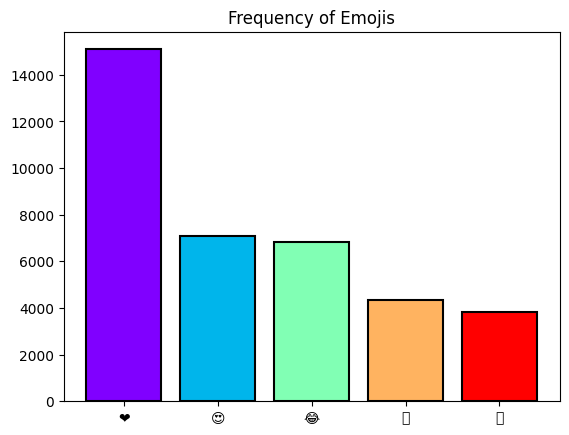

In [126]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#plt.rcParams['font.family'] = 'DejaVu Sans'
emoji_counts = df["emoticons"].value_counts()
colors = plt.cm.rainbow(np.linspace(0, 1, len(emoji_counts)))
plt.bar(
    emoji_counts.index,
    emoji_counts.values,
    color=colors,
    edgecolor='black',
    linewidth=1.5
)
# Customizing the plot
plt.title("Frequency of Emojis")
plt.grid(False)  # Optionally turn off grid


In [93]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import os

# Set a specific download directory (Kaggle typically has /root/nltk_data as a default)
nltk_data_dir = '/root/nltk_data'
os.makedirs(nltk_data_dir, exist_ok=True)

# Append the NLTK data directory to the search path
nltk.data.path.append(nltk_data_dir)

# Download the resources
nltk.download('wordnet', download_dir=nltk_data_dir)
nltk.download('stopwords', download_dir=nltk_data_dir)
nltk.download('omw-1.4', download_dir=nltk_data_dir)
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
replace /usr/share/nltk_data/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [135]:
def preprocess_text(text):
    # lower text
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#', '', text)
    # Remove special characters
    text = re.sub(r'[^a-z\s]', '', text)

    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    clean_text = ' '.join(tokens)
    return clean_text

In [136]:
df['cleaned_text'] = df['TEXT'].apply(preprocess_text)

In [137]:
df["TEXT"].apply(len).max()

142

In [138]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

max_length = 100
X = pad_sequences(sequences, maxlen=max_length)
y = df['Label'].values


In [139]:
pd.Series(df['Label'].values).unique()

array([0, 1, 2, 3, 4])

In [140]:
from gensim.models import Word2Vec

# Tokenize the cleaned text for Word2Vec training
sentences = [text.split() for text in df['cleaned_text'].values]

# Train the Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)

# Save the model (optional)
word2vec_model.save("word2vec.model")

vocab_size = len(tokenizer.word_index) + 1  # Add 1 for padding index
embedding_dim = 300  # The same as Word2Vec vector size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, index in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[index] = word2vec_model.wv[word]
    else:
        # Random initialization for words not in Word2Vec
        embedding_matrix[index] = np.random.randn(embedding_dim)

In [141]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(zip(np.unique(y), class_weights))

sample_weights = np.array([class_weights_dict[label] for label in y])


X_train, X_test, y_train, y_test, sample_weights_train, sample_weights_test = train_test_split(
    X, y, sample_weights, test_size=0.15, random_state=42, stratify=y
)


In [142]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
checkpoint_callback = ModelCheckpoint(
    filepath='/kaggle/working/texttoemoji_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)


from tensorflow.keras.callbacks import ReduceLROnPlateau


reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.1,          
    patience=6,          
    min_lr=1e-5,         
    verbose=1            
)


In [143]:
X_train.shape

(31632, 100)

In [144]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, MultiHeadAttention, Flatten,Input

In [145]:
input_layer = Input(shape=(max_length,), name='Input_Layer')
embedding_layer = Embedding(input_dim=len(tokenizer.word_index)+1, 
                            output_dim=embedding_dim, 
                            weights=[embedding_matrix], 
                            input_length=max_length, 
                            trainable=True, 
                            name='Embedding_Layer')(input_layer)
bidirectional_lstm = Bidirectional(LSTM(units=64, return_sequences=True), name='Bidirectional_LSTM')(embedding_layer)
batch_norm = BatchNormalization(name='BatchNormalization')(bidirectional_lstm)

dropout_1 = Dropout(0.3, name='Dropout_1')(batch_norm)
multi_head_attention = MultiHeadAttention(num_heads=20, key_dim=embedding_dim, name='MultiHead_Attention')(dropout_1, dropout_1,dropout_1)
flatten = Flatten(name='Flatten')(multi_head_attention)

dense = Dense(units=32, activation='relu', name='Dense_Layer')(flatten)
dropout_3 = Dropout(0.2, name='Dropout_3')(dense)

output_layer = Dense(units=5, activation='softmax', name='Output_Layer')(dropout_3)

model = Model(inputs=input_layer, outputs=output_layer)
model.build(input_shape=(None, max_length)) 

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Embedding_Layer     │ (None, 100, 300)  │ 13,766,100 │ Input_Layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Bidirectional_LSTM  │ (None, 100, 128)  │    186,880 │ Embedding_Layer[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BatchNormalization  │ (None, 100, 128)  │        512 │ Bidirectional_LS… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_1 (Dropout) │ (None, 100, 128)  │          0 │ BatchNormalizati… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MultiHead_Attention │ (None, 100, 128)  │  3,090,128 │ Dropout_1[0][0],  │
│ (MultiHeadAttentio… │                   │            │ Dropout_1[0][0],  │
│                     │                   │            │ Dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Flatten (Flatten)   │ (None, 12800)     │          0 │ MultiHead_Attent… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Layer (Dense) │ (None, 32)        │    409,632 │ Flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_3 (Dropout) │ (None, 32)        │          0 │ Dense_Layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Layer        │ (None, 5)         │        165 │ Dropout_3[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,453,417 (66.58 MB)

 Trainable params: 17,453,161 (66.58 MB)

 Non-trainable params: 256 (1.00 KB)

In [146]:
model.fit(X_train, y_train,
          epochs=150, batch_size=64,
          validation_data=(X_test, y_test),
          sample_weight=sample_weights_train,
          callbacks=[checkpoint_callback,reduce_lr_callback] )

Epoch 1/150
495/495 ━━━━━━━━━━━━━━━━━━━━ 62s 117ms/step - accuracy: 0.2711 - loss: 1.5307 - val_accuracy: 0.2524 - val_loss: 1.4835 - learning_rate: 1.0000e-04
Epoch 2/150
495/495 ━━━━━━━━━━━━━━━━━━━━ 60s 121ms/step - accuracy: 0.3541 - loss: 1.3009 - val_accuracy: 0.2954 - val_loss: 1.4609 - learning_rate: 1.0000e-04
Epoch 3/150
495/495 ━━━━━━━━━━━━━━━━━━━━ 61s 124ms/step - accuracy: 0.4097 - loss: 1.1710 - val_accuracy: 0.3195 - val_loss: 1.4030 - learning_rate: 1.0000e-04
Epoch 4/150
495/495 ━━━━━━━━━━━━━━━━━━━━ 61s 122ms/step - accuracy: 0.4482 - loss: 1.0651 - val_accuracy: 0.2497 - val_loss: 1.8206 - learning_rate: 1.0000e-04
Epoch 5/150
495/495 ━━━━━━━━━━━━━━━━━━━━ 60s 122ms/step - accuracy: 0.4956 - loss: 0.9758 - val_accuracy: 0.2980 - val_loss: 2.0005 - learning_rate: 1.0000e-04
Epoch 6/150
495/495 ━━━━━━━━━━━━━━━━━━━━ 61s 122ms/step - accuracy: 0.5344 - loss: 0.9033 - val_accuracy: 0.3178 - val_loss: 1.7908 - learning_rate: 1.0000e-04
Epoch 7/150
495/495 ━━━━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 